# Clustering

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from datetime import datetime
from IPython.display import HTML
from matplotlib import animation
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 40, 35
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 25

# Dataset cleaner
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    # return df[indices_to_keep].astype(np.float64)
    return df[indices_to_keep]

# DBSCAN Plot
def plot_DBscan(x, y, db):
    labels = db.labels_
    sizes = [1 if l == -1 else 10 for l in db.labels_]
    plt.scatter(x, y, c=db.labels_, zorder=3, s=sizes)

# Data - PM2.5

# Part I

In [2]:
df = pd.read_csv('./PM2.5/PM2.5.csv')
# df.head()

In [3]:
print("Number of unique latitude = %d " %len(df['lat'].unique()))
print("Number of unique longitude = %d " %len(df['lon'].unique()))

Number of unique latitude = 637 
Number of unique longitude = 553 


In [4]:
# # Keep only 'lat' and 'lon'.
# df_lite = df[['lat', 'lon']].drop_duplicates()
# df_lite.count()

In [5]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html
# Q: How can I keep mean of PM25, Temperature and Humidity after dropping based on lat and lon?

# Drop objects which have duplicated ['lat', 'lon'] combination.
df_lite = df.drop_duplicates(subset=['lat', 'lon'] , keep='first')

In [6]:
# df_lite.count()
# df_lite.head()

## GPS Location Clustering 1 - K-Means (Observation)
------------------------------------------------------------------------------------------
#### Step 1: Observation of number of clusters
- Number of clusters: [1, 2, 3, 4, 5, 6, 7, 8, 9]
    - My expectation for number of clusters is K = 4 which clusters Taiwan into Northern, Central, Southern, and Eastern Taiwan.
    - More clusters might show groups representing different disctricts.
        - K = 6 shows clear boundaries of major districts: Taipei, Taichung, Tainan, Kaochung, and Eastern Taiwan.
        - K = 9 shows even much clearer boundaries of different districts. For example: Yilan is distinguishable like other major cities such as Taipei, Hsinchu, Taichung, Tainan, etc. However, Hualien and Taitung have too few sensors so that they are not distinguishable. Both of them are in the same cluster.

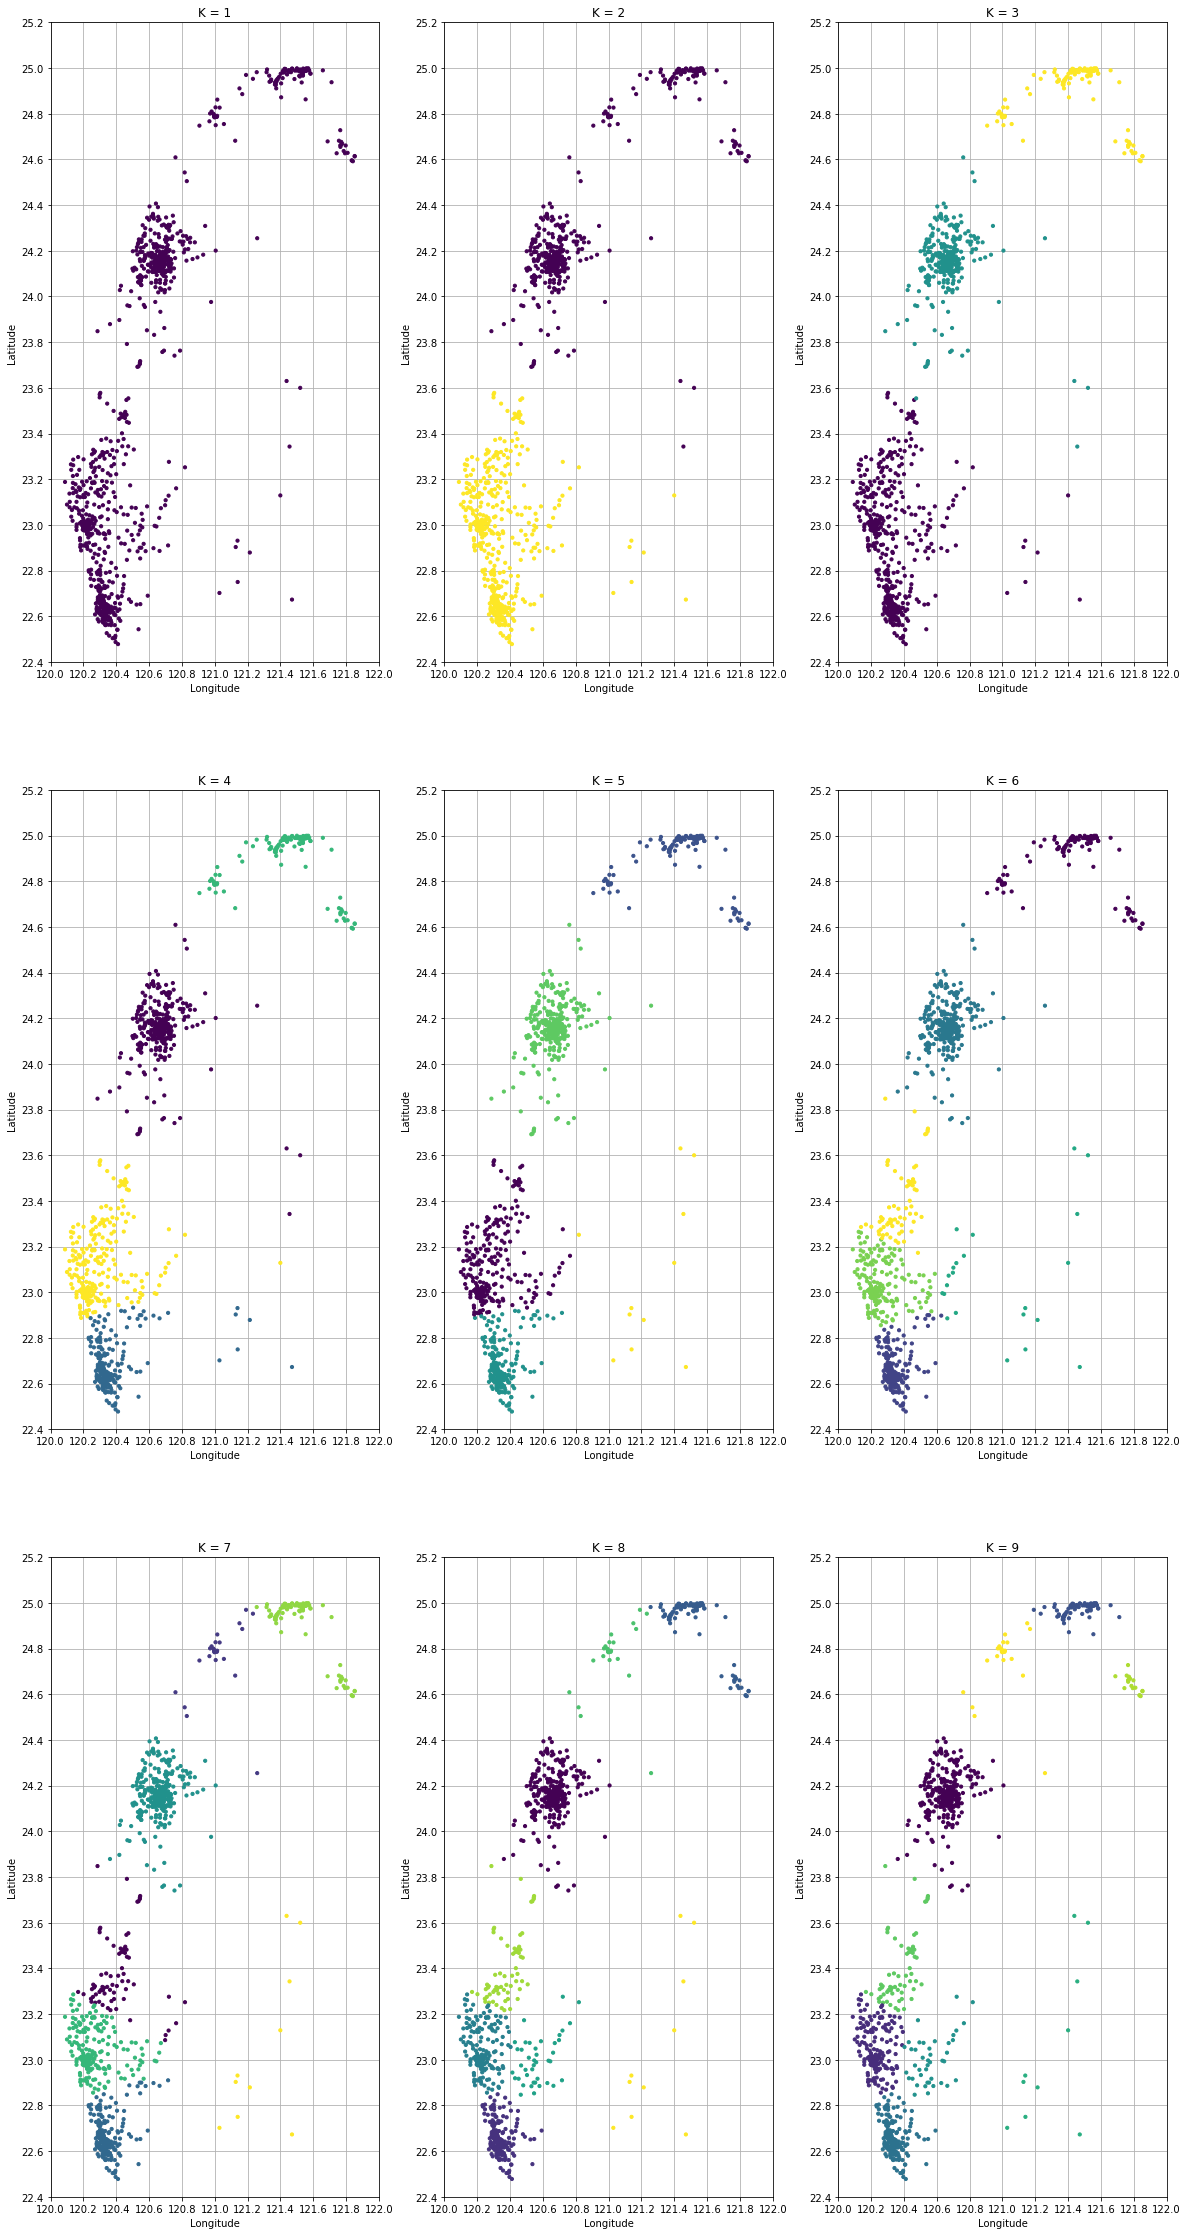

In [7]:
coordinate = df_lite.as_matrix(columns=['lat', 'lon'])
x, y = coordinate[:, 1], coordinate[:, 0]

k_min = 1
k_max = 9
k_inter = 1

fig = plt.figure(figsize=(20,40))
for i in range(k_min, k_max + k_inter, k_inter):
    plt.subplot(3, 3, i)
    plt.title('K = ' + str(i))
    plt.grid(b=True)
    # x and y settings are based on location of Taiwan
    plt.ylabel('Latitude')
    plt.ylim(22.4, 25.2)
    plt.yticks(np.arange(22.4, 25.2, 0.2))
    plt.xlabel('Longitude')
    plt.xlim(120, 122)
    plt.xticks(np.arange(120, 122.1, 0.2))
    kmeans = KMeans(n_clusters=i).fit(coordinate)
    plt.scatter(x, y, c=kmeans.labels_, zorder=3, s=10)

## GPS Location Clustering 1 - K-Means (Evaluation)
------------------------------------------------------------------------------------------
#### Step 2-1: Evaluation of K-Means clustering by Elbow method (Calculating SSE)
- Conclusion
    - According to the Elbow method shown below, 4 clusters seems to be enough.
    - Based on our domain knowledge of Taiwan geography, 4 cluster should be Northern, Central, Southern, and Eastern Taiwan.
    - However, the result of K-Means with K = 4 shown above obviously does not fulfill our expectation.
    - Increase number of clusters to K = 6 better shows the characteristics of Taiwan district distribution.
    - Hence, the evaluation based on SSE is not quite reliable in this case.

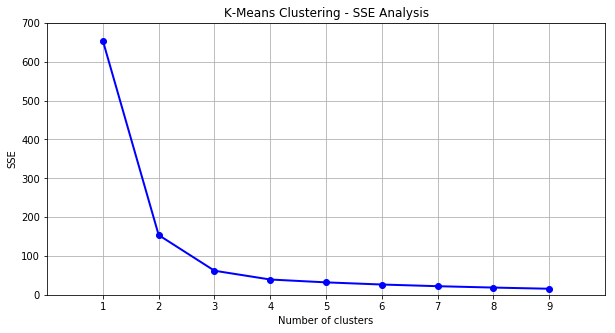

In [8]:
SSE = {}
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters=k).fit(coordinate)
    # Inertia: Sum of distances of samples to their closest cluster center
    SSE[k] = kmeans.inertia_
fig = plt.figure(figsize=(10,5))
plt.plot(SSE.keys(), SSE.values(), 'bo-')
plt.title('K-Means Clustering - SSE Analysis')
plt.xlabel('Number of clusters')
plt.xlim(0, k_max+1)
plt.xticks(np.arange(1, k_max+1, 1))
plt.ylabel('SSE')
plt.ylim(0, 700)
plt.yticks(np.arange(0, 701, 100))
plt.grid(True)
plt.show()

## GPS Location Clustering 1 - K-Means
------------------------------------------------------------------------------------------
#### Step 2-2: Evaluation of K-Means clustering by Silhouette method
- Conclusion
    - As stated previously, K = 6 or above would be a better choice that accurately describes Taiwan districts.
    - Sihoutette evaluation shows that K = 2 and 3 are better. 
    - However, it contradicts with our expectation and knowledge. 
    - Elbow method by computing SSE should be a better tool for evaluation.

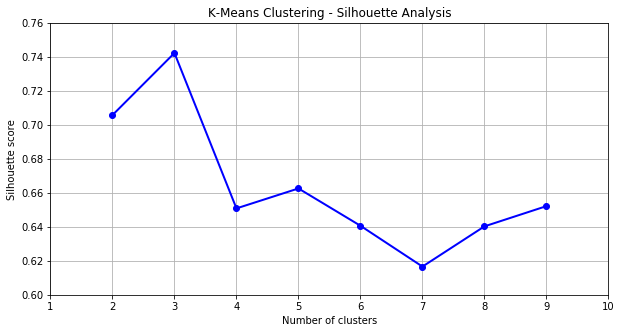

In [9]:
score = []
for k in range(2, k_max+1):
    kmeans = KMeans(n_clusters=k).fit(coordinate)
    score.append(metrics.silhouette_score(coordinate, kmeans.labels_))
    
fig = plt.figure(figsize=(10,5))
plt.plot(range(2, k_max+1), score, 'bo-')
plt.title('K-Means Clustering - Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.xlim(1, k_max+1)
plt.xticks(np.arange(1, k_max+2, 1))
plt.ylabel('Silhouette score')
plt.ylim(0.60, 0.75)
plt.yticks(np.arange(0.60, 0.76, 0.02))
plt.grid(True)
plt.show()

## GPS Location Clustering 1 - K-Means (Conclusion)
------------------------------------------------------------------------------------------
#### Conclusion
- K-Means is an appropriate choice since all the sensors are not outlier, namely, all within Taiwan, and K-means behaves well when there is no outlier.
- Using K = 6 shows clear boundaries of major districts: Taipei, Taichung, Tainan, Kaochung, and Eastern Taiwan.
- Using K = 9 has great clustering performance. It reveals different districts of Taiwan clearly.

## GPS Location Clustering 2 - DBSCAN (Observation)
------------------------------------------------------------------------------------------
#### Step 1: Observation of DBSCAN - Keep Eps and sweep MinPts
- An initial Eps has to be determined: Eps too high results in only one group, and too low results in too many outliers.
- Initial Eps is 0.04.
- MinPts is swept from 3 to 19.
- metric is 'haversine' instead of euclidean because our data are longitude and latitude. 'haversine' considers the round surface of the earth.
- MinPts > 7, number of ourliers increases drastically.
- Hence, under the circumstances of Eps = 0.04, a better choice of MinPts <= 7.
- However, the geographical clustering based on DBSCAN is not suitable due to the sensor density of each cluster is not homogeneous. Besides, all sensors are not outliers from the perspective of GPS location, since they are all in Taiwan.
- Shared Near Neighbor (SNN) DBSCAN should be a better approach to overcome heterogeneous density problem.
- K-Means is a better method than traditional DBSCAN.

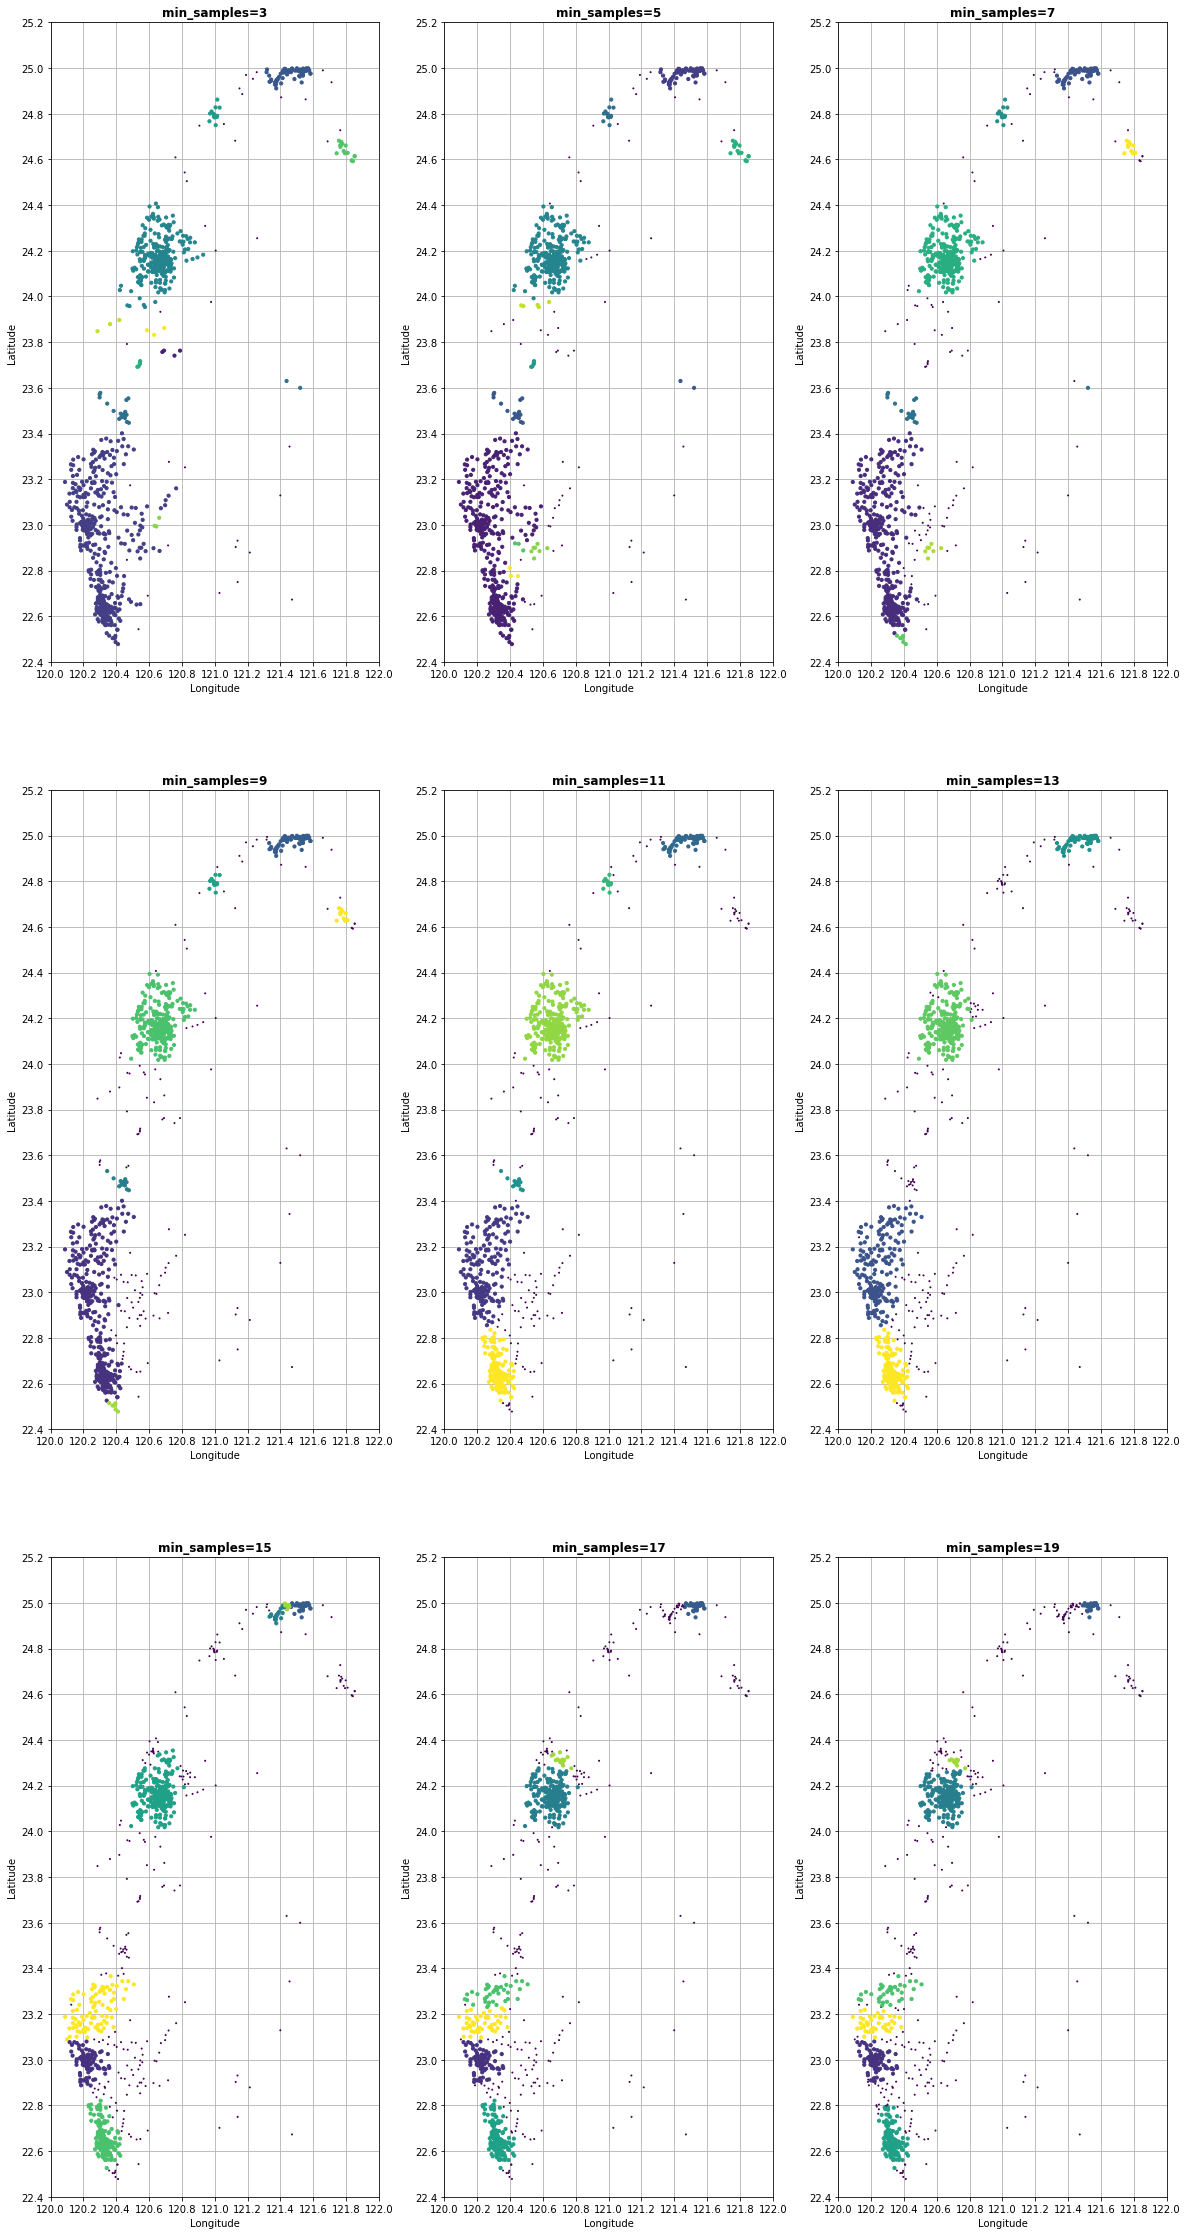

In [10]:
coordinate = df_lite.as_matrix(columns=['lat', 'lon'])
x, y = coordinate[:, 1], coordinate[:, 0]

fig = plt.figure(figsize=(20,40))
eps = 0.04
for minPts in range(3, 19+1, 2):
    plt.subplot(3, 3, (minPts - 1) / 2)
    db = DBSCAN(eps=eps, min_samples=minPts, metric='haversine').fit(coordinate)
    plot_DBscan(x, y, db)
    plt.title('min_samples='+str(minPts), fontweight='bold')
    
    plt.grid(b=True)
    # x and y settings are based on location of Taiwan
    plt.ylabel('Latitude')
    plt.ylim(22.4, 25.2)
    plt.yticks(np.arange(22.4, 25.2, 0.2))
    plt.xlabel('Longitude')
    plt.xlim(120, 122)
    plt.xticks(np.arange(120, 122.1, 0.2))

## GPS Location Clustering 2 - DBSCAN (Observation)
------------------------------------------------------------------------------------------
#### Step 2: Observation of DBSCAN - Keep MinPts and sweep Eps
- Based on the above experiment, MinPts is set as 7.
- Eps is swept from 0.01 to 0.09.
- metric is 'haversine' instead of euclidean because our data are longitude and latitude. 'haversine' considers the round surface of the earth.
- Eps < 0.04, number of ourliers increases drastically.
- Hence, under the circumstances of MinPts = 7, a better choice of Eps >= 0.04.
- However, the geographical clustering based on DBSCAN is not suitable due to the sensor density of each cluster is not homogeneous. Besides, all sensors are not outliers from the perspective of GPS location, since they are all in Taiwan.
- Shared Near Neighbor (SNN) DBSCAN should be a better approach to overcome heterogeneous density problem.
- K-Means is a better method than traditional DBSCAN.

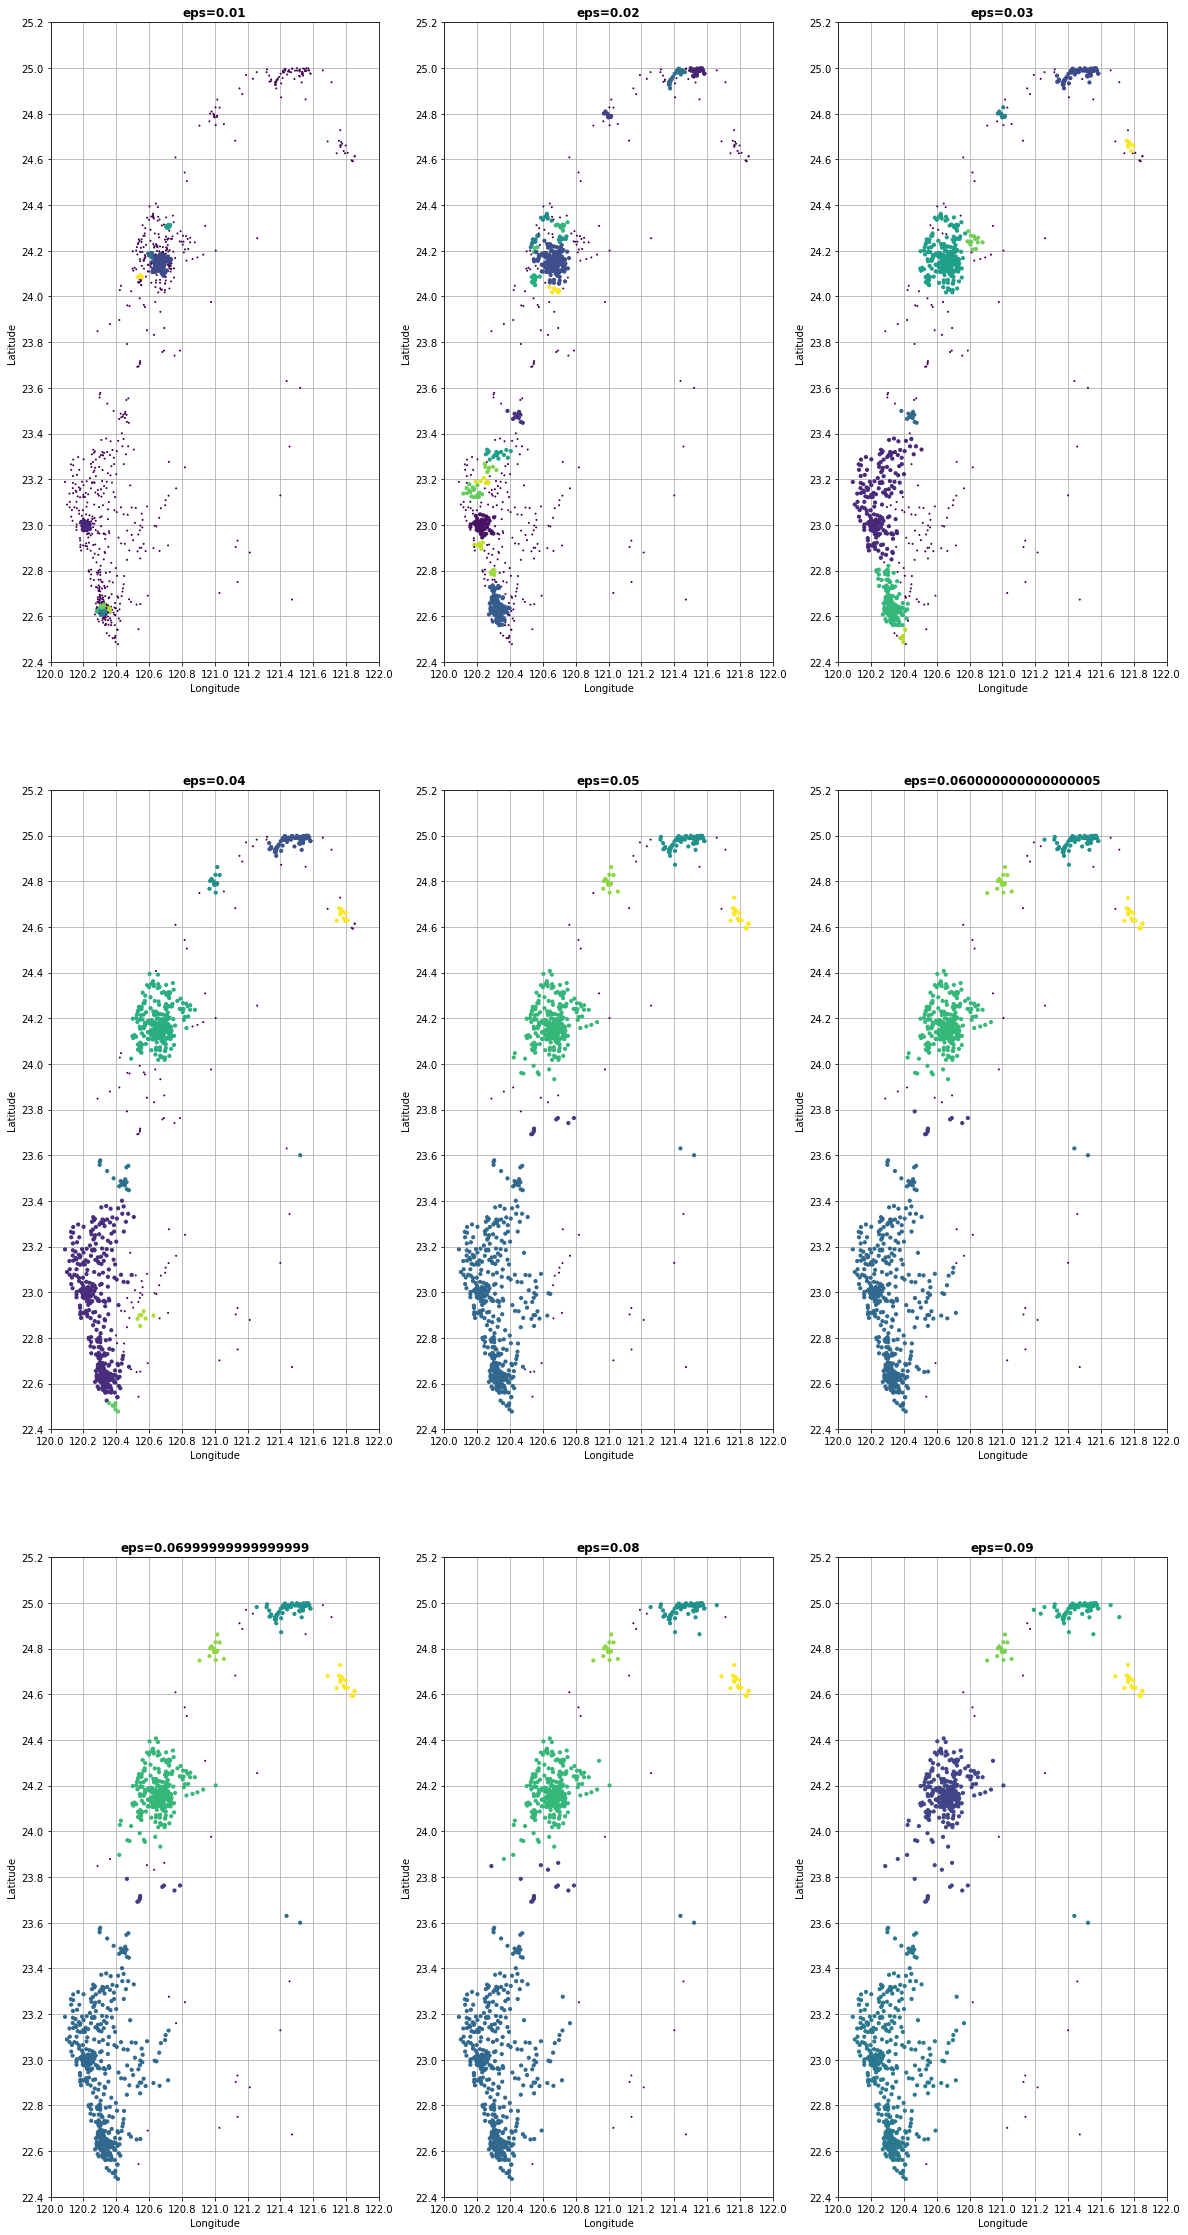

In [11]:
coordinate = df_lite.as_matrix(columns=['lat', 'lon'])
x, y = coordinate[:, 1], coordinate[:, 0]

fig = plt.figure(figsize=(20,40))
minPts = 7
for idx, eps in enumerate(list(np.arange(0.01, 0.1, 0.01))):
    plt.subplot(3, 3, idx+1)
    db = DBSCAN(eps=eps, min_samples=minPts, metric='haversine').fit(coordinate)
    plot_DBscan(x, y, db)
    plt.title('eps='+str(eps), fontweight='bold')
    
    plt.grid(b=True)
    # x and y settings are based on location of Taiwan
    plt.ylabel('Latitude')
    plt.ylim(22.4, 25.2)
    plt.yticks(np.arange(22.4, 25.2, 0.2))
    plt.xlabel('Longitude')
    plt.xlim(120, 122)
    plt.xticks(np.arange(120, 122.1, 0.2))

## GPS Location Clustering 2 - DBSCAN (Conclusion)
------------------------------------------------------------------------------------------
#### Conclusion
- Using traditional DBSCAN is not appropriate due to heterogeneous sensor density.
- If DBSCAN is the only tool, then using Eps = 0.04 and MinPts = 7 has an acceptable clustering result.
- Other possible clustering methods that might be better than DBSCAN:
    - Shared Near Neighbor (SNN) DBSCAN might be helpful.
    - K-Means is also a good choice as shown previously since all the sensors are not outlier, and K-means behaves well when there is no outlier.

# Part II

## PM2.5 Clustering 1 - K-Means (Observation)
------------------------------------------------------------------------------------------
#### Step 1: Observation of number of clusters
- Number of clusters: [2, 4, 6, 8, 10, 12]
    - PM2.5 data will be clustered by K-Means and plotted based on the geographical coordinate.

In [12]:
df = pd.read_csv('./PM2.5/PM2.5.csv')

In [13]:
# Get the mean of PM25, PM10, PM1, Temperature, and Humidity for each GPS location.
# df.groupby(['lat', 'lon'])['PM25', 'PM10', 'PM1', 'Temperature', 'Humidity'].mean()

In [14]:
# Create new dataset: df_lite
df_lite = df.drop_duplicates(subset=['lat', 'lon'] , keep='first')
df_lite['PM25'] = list(df.groupby(['lat', 'lon'])['PM25'].max()) # Get maximum of PM25
df_lite['PM10'] = list(df.groupby(['lat', 'lon'])['PM10'].max())
df_lite['PM1'] = list(df.groupby(['lat', 'lon'])['PM1'].max())
df_lite['Temperature'] = list(df.groupby(['lat', 'lon'])['Temperature'].mean())
df_lite['Humidity'] = list(df.groupby(['lat', 'lon'])['Humidity'].mean())
df_lite.head()

,record_id,device_id,DateTime,PM25,PM10,PM1,Temperature,Humidity,lat,lon
0,12773,28C2DDDD415C,2017-03-01 08:30:00,117,145,86,26.630816,95.964650,23.741,120.755
1471,14244,28C2DDDD415F,2017-03-05 13:30:00,283,367,197,26.272041,76.725850,22.996,120.222
2740,25530,28C2DDDD423C,2017-03-01 08:30:00,95,114,70,28.654466,68.604351,24.990,121.576
4211,31991,28C2DDDD42C7,2017-03-10 12:00:00,115,139,81,27.151074,74.681849,24.983,121.534
5243,33023,28C2DDDD42F7,2017-03-05 14:00:00,114,134,81,26.870789,80.001360,24.998,121.539


In [15]:
# The following codes are to help me understand the exact clustering range by K-Means.
# coordinate = df_lite.as_matrix(columns=['lat', 'lon'])
# x, y = coordinate[:, 1], coordinate[:, 0]
# kmeans = KMeans(n_clusters=2).fit(df_lite[['PM25']])
# df_lite['kmeans_labels'] = kmeans.labels_

# df_lite.groupby('kmeans_labels').count()

# # Notify the upper/lower bounds of kmeans_labels
# max_list = list(df_lite.groupby('kmeans_labels')['PM25'].max())
# min_list = list(df_lite.groupby('kmeans_labels')['PM25'].min())

# # Modify kmeans_labels's value by specific upper/lower bounds
# df_lite[['kmeans_labels']] = ["[%d, %d]" % (min_list[i], max_list[i]) for i in df_lite['kmeans_labels']]
# df_lite.groupby('kmeans_labels').count()

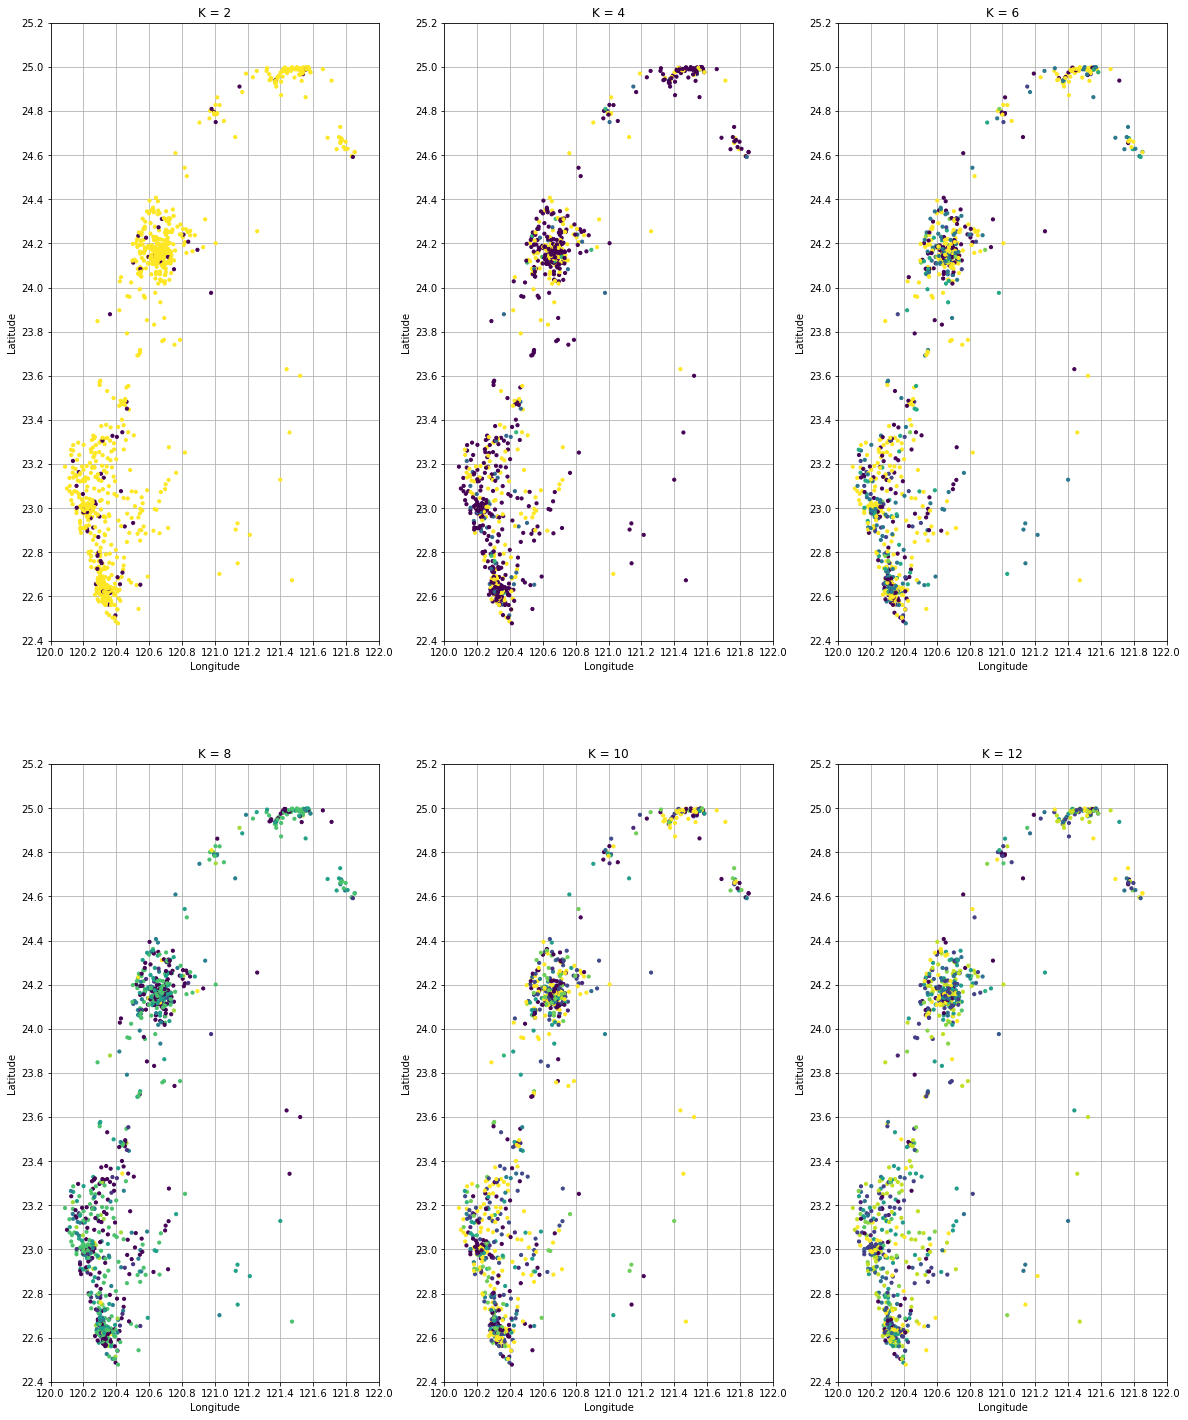

In [16]:
coordinate = df_lite.as_matrix(columns=['lat', 'lon'])
x, y = coordinate[:, 1], coordinate[:, 0]

k_min = 2
k_max = 12
k_inter = 2

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20,25))
for i in range(k_min, k_max + k_inter, k_inter):
    plt.subplot(2, 3, int(i/2))
    plt.title('K = ' + str(i))
    plt.grid(b=True)
    # x and y settings are based on location of Taiwan
    plt.ylabel('Latitude')
    plt.ylim(22.4, 25.2)
    plt.yticks(np.arange(22.4, 25.2, 0.2))
    plt.xlabel('Longitude')
    plt.xlim(120, 122)
    plt.xticks(np.arange(120, 122.1, 0.2))
    kmeans = KMeans(n_clusters=i).fit(df_lite[['PM25']])
    
    df_lite['kmeans_labels'] = kmeans.labels_
    max_list = list(df_lite.groupby('kmeans_labels')['PM25'].max())
    min_list = list(df_lite.groupby('kmeans_labels')['PM25'].min())
    plt.scatter(x, y, c=kmeans.labels_, zorder=3, s=10)
    
    # plt.scatter(x, y, c=kmeans.labels_, zorder=3, s=10, label=(["[%d, %d]" %(min_list[int(x/2)], max_list[int(x/2)]) for x in range(int(i/2)+1)]))
    # plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    

## PM2.5 Clustering 1 - K-Means (Evaluation)
------------------------------------------------------------------------------------------
#### Step 2-1: Evaluation of K-Means clustering by Elbow method (Calculating SSE)
- Conclusion
    - According to the Elbow method shown below, 5 clusters seems to be enough.

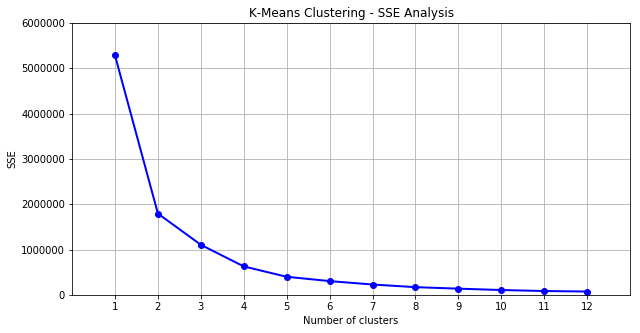

In [17]:
SSE = {}
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters=k).fit(df_lite[['PM25']])
    # Inertia: Sum of distances of samples to their closest cluster center
    SSE[k] = kmeans.inertia_
fig = plt.figure(figsize=(10,5))
plt.plot(SSE.keys(), SSE.values(), 'bo-')
plt.title('K-Means Clustering - SSE Analysis')
plt.xlabel('Number of clusters')
plt.xlim(0, k_max+1)
plt.xticks(np.arange(1, k_max+1, 1))
plt.ylabel('SSE')
plt.ylim(0, 6000000)
# plt.yticks(np.arange(0, 701, 100))
plt.grid(True)
plt.show()

## PM2.5 Clustering 2 - DBSCAN (Observation)
------------------------------------------------------------------------------------------
#### Step 1: Observation of DBSCAN - Keep MinPts and sweep Eps
- Initial minPts = 3
- eps is swept from 0.01 to 0.12 with step size of 0.02

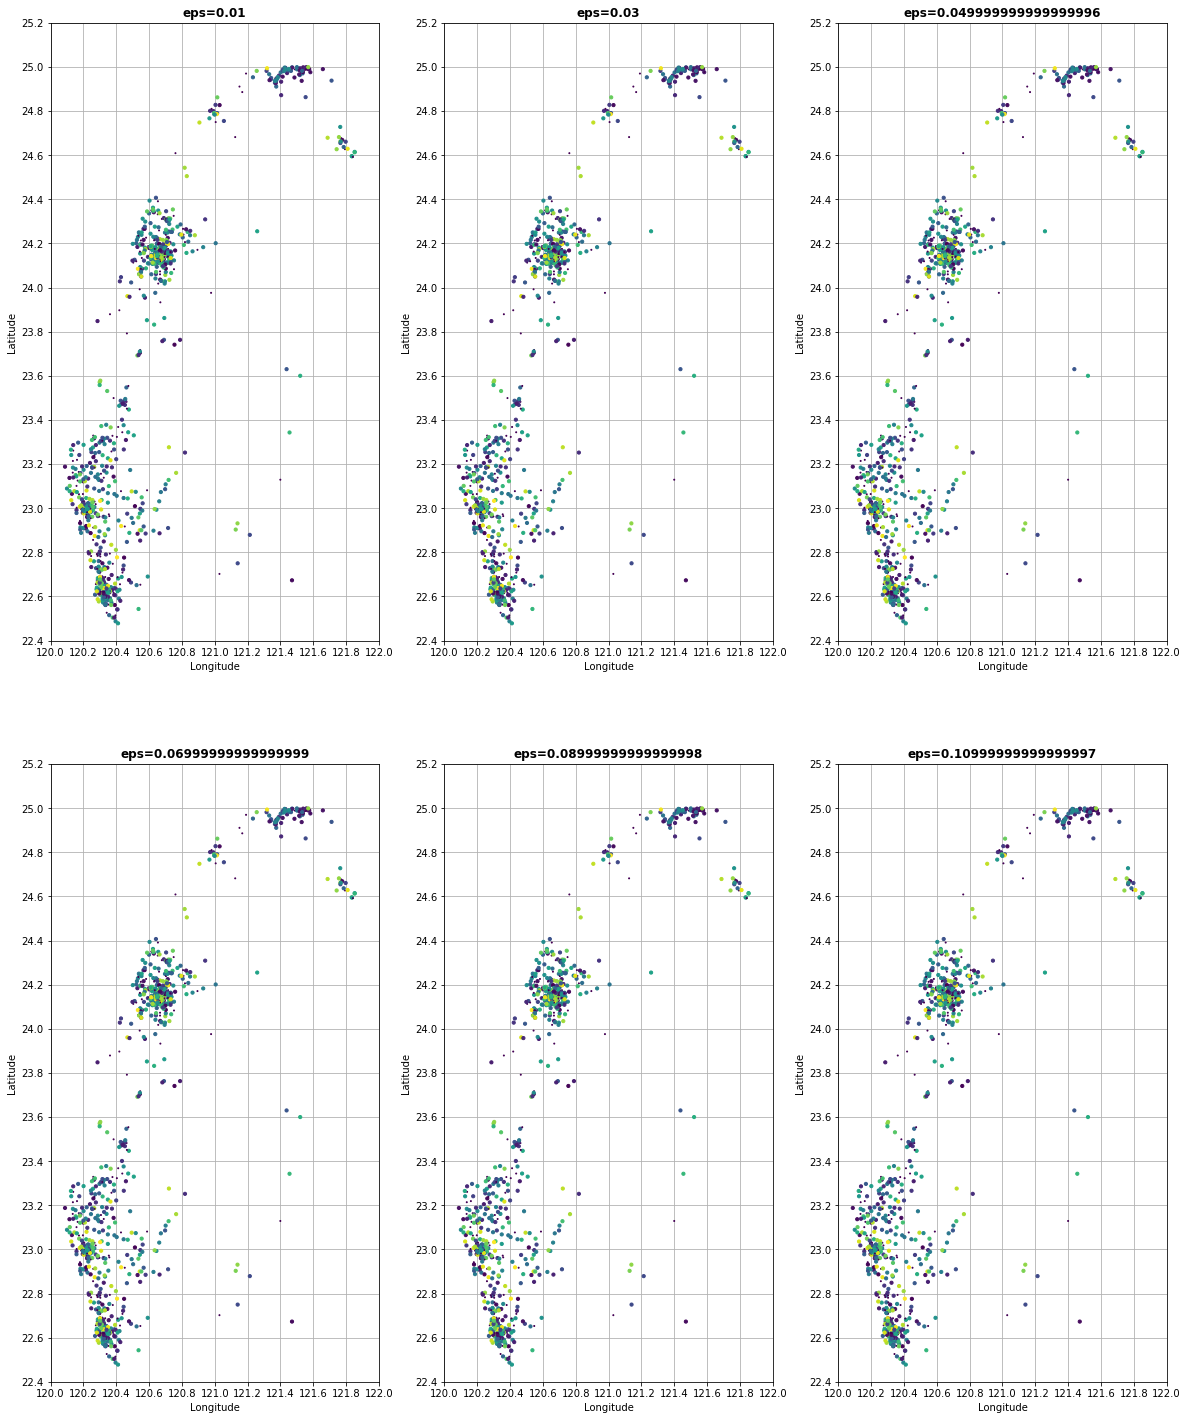

In [18]:
coordinate = df_lite.as_matrix(columns=['lat', 'lon'])
x, y = coordinate[:, 1], coordinate[:, 0]

fig = plt.figure(figsize=(20,25))
minPts = 3
for idx, eps in enumerate(list(np.arange(0.01, 0.12, 0.02))):
    plt.subplot(2, 3, idx+1)
    db = DBSCAN(eps=eps, min_samples=minPts, metric='euclidean').fit(df_lite[['PM25']])
    plot_DBscan(x, y, db)
    plt.title('eps='+str(eps), fontweight='bold')
    
    plt.grid(b=True)
    # x and y settings are based on location of Taiwan
    plt.ylabel('Latitude')
    plt.ylim(22.4, 25.2)
    plt.yticks(np.arange(22.4, 25.2, 0.2))
    plt.xlabel('Longitude')
    plt.xlim(120, 122)
    plt.xticks(np.arange(120, 122.1, 0.2))

## PM2.5 Clustering 2 - DBSCAN (Conclusion)
------------------------------------------------------------------------------------------
#### Conclusion
- The DBSCAN clustering on PM2.5 is actually quite intuitive, since PM2.5 is a 1-D data.
- Plot the PM2.5 clustering data on real geography is for us to easily observe the distribution of different PM2.5.

# Part III

## Humidity and Temperatur Clustering 1 - K-Means (Observation)
------------------------------------------------------------------------------------------
#### Step 1: Observation of number of clusters
- Number of clusters: [2, 4, 6, 8, 10, 12]
    - [Humidity, Temperature] data will be clustered by K-Means.

In [19]:
df = pd.read_csv('./PM2.5/PM2.5.csv')
df_lite = df.drop_duplicates(subset=['Humidity', 'Temperature'] , keep='first')

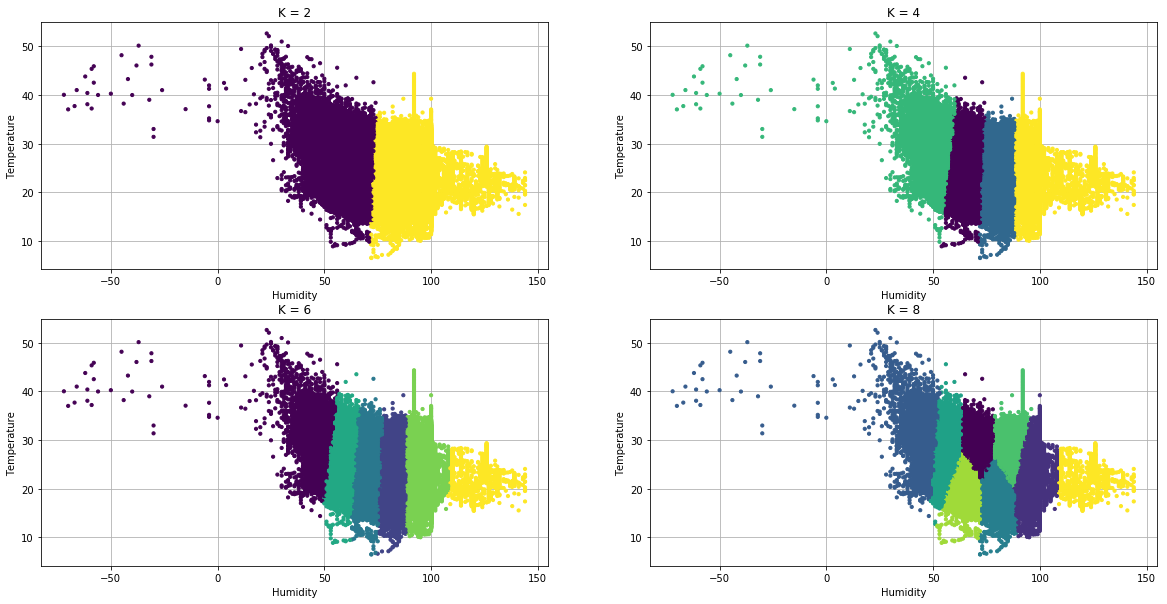

In [20]:
h2PM25 = df_lite.as_matrix(columns=['Humidity', 'Temperature'])
x, y = h2PM25[:, 0], h2PM25[:, 1]

# fig = plt.figure(figsize=(20,10))
# plt.scatter(x, y, c='g', zorder=3, s=20)
# plt.show()

k_min = 2
k_max = 8
k_inter = 2

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20,10))
for i in range(k_min, k_max + k_inter, k_inter):
    plt.subplot(2, 2, int(i/2))
    plt.title('K = ' + str(i))
    plt.grid(b=True)
    plt.ylabel('Temperature')
    plt.xlabel('Humidity')
    kmeans = KMeans(n_clusters=i).fit(h2PM25)
    plt.scatter(x, y, c=kmeans.labels_, zorder=3, s=10)

## Humidity and Temperatur Clustering 1 - K-Means (Evaluation)
------------------------------------------------------------------------------------------
#### Step 2-1: Evaluation of K-Means clustering by Elbow method (Calculating SSE)
- Conclusion
    - According to the Elbow method shown below, 4 clusters seems to be enough.

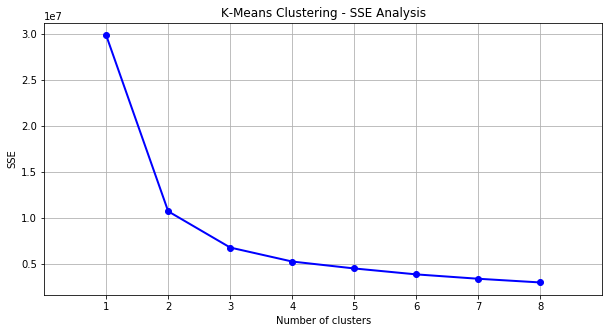

In [21]:
SSE = {}
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters=k).fit(h2PM25)
    # Inertia: Sum of distances of samples to their closest cluster center
    SSE[k] = kmeans.inertia_
fig = plt.figure(figsize=(10,5))
plt.plot(SSE.keys(), SSE.values(), 'bo-')
plt.title('K-Means Clustering - SSE Analysis')
plt.xlabel('Number of clusters')
plt.xlim(0, k_max+1)
plt.xticks(np.arange(1, k_max+1, 1))
plt.ylabel('SSE')
# plt.ylim(0, 6000000)
# plt.yticks(np.arange(0, 701, 100))
plt.grid(True)
plt.show()

## Humidity and Temperatur Clustering 2 - DBSCAN (Observation)
------------------------------------------------------------------------------------------
#### Step 1: Observation of DBSCAN - Keep MinPts and sweep Eps
- Initial minPts = 2
- eps is swept from 0.01 to 0.08 with step size of 0.02

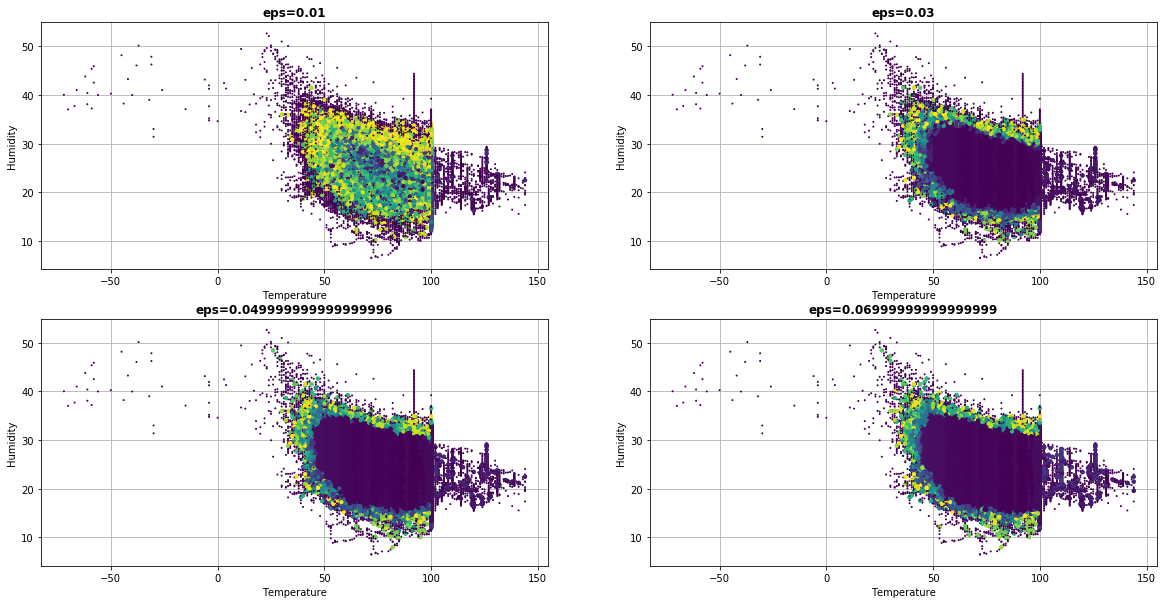

In [22]:
h2PM25 = df_lite.as_matrix(columns=['Humidity', 'Temperature'])
x, y = h2PM25[:, 0], h2PM25[:, 1]

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20,10))
minPts = 2
for idx, eps in enumerate(list(np.arange(0.01, 0.08, 0.02))):
    plt.subplot(2, 2, idx+1)
    db = DBSCAN(eps=eps, min_samples=minPts, metric='euclidean').fit(h2PM25)
    plot_DBscan(x, y, db)
    plt.title('eps='+str(eps), fontweight='bold')
    plt.grid(b=True)
    # x and y settings are based on location of Taiwan
    plt.ylabel('Humidity')
    plt.xlabel('Temperature')

## Humidity and Temperatur Clustering 2 - DBSCAN (Conclusion)
------------------------------------------------------------------------------------------
#### Conclusion
- Actually, I cannot give any insigtful observation regarding DBSCAN clustering on [Humidity, Temperature] data.
- The data are crowded into one certain region, making other regions be clustered as outlier.
- This problem is mainly due to the density difference between different cluster is too high.
- As stated previously, Shared Near Neighbor (SNN) DBSCAN or K-Means might be more helpful than traditional DBSCAN on this analysis.